<a href="https://colab.research.google.com/github/ali-workshop/Colorization-using-deep-learning-GAN/blob/main/Colorization_DEEP_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aayush9753/image-colorization-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 465M/473M [00:04<00:00, 89.0MB/s]
100% 473M/473M [00:05<00:00, 98.7MB/s]


In [ ]:
!unzip /content/image-colorization-dataset.zip

In [ ]:
import os
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, RepeatVector
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import gray2rgb, rgb2gray, rgb2lab, lab2rgb
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
X = []
for filename in os.listdir('/content/data/train_color')[:20]:
    X.append(img_to_array(load_img('/content/data/train_color/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [ ]:
Xtrain.shape

(20, 400, 400, 3)

In [ ]:
inception = InceptionResNetV2(include_top=True)
embed_input = Input(shape=(1000,))

encoder_input = Input(shape=(400, 400, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(50 * 50)(embed_input)
fusion_output = Reshape(([50, 50, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

225209952/225209952 [==============================] - 2s 0us/step


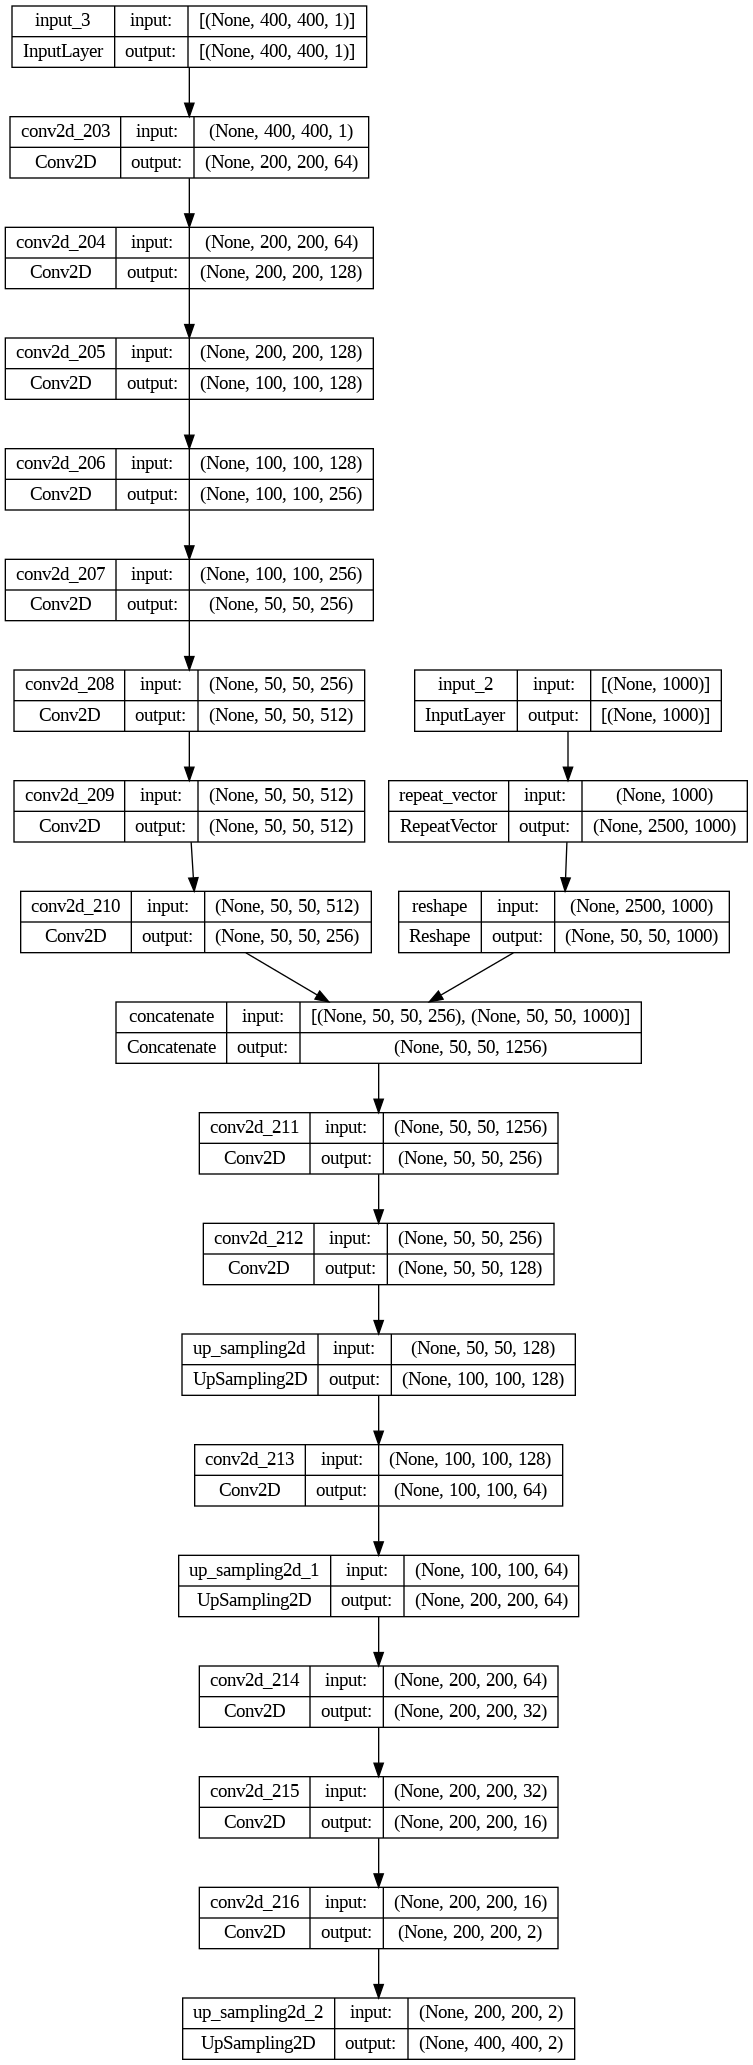

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

#Generate training data
batch_size = 20

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


In [ ]:
model.fit(image_a_b_gen(batch_size), epochs=1000, steps_per_epoch=1, verbose = 1)#epochs=1000

1/1 [==============================] - 0s 73ms/step
Epoch 1/1000
1/1 [==============================] - 35s 35s/step - loss: 0.0554
Epoch 2/1000
1/1 [==============================] - 1s 556ms/step - loss: 0.0546
Epoch 3/1000
1/1 [==============================] - 1s 570ms/step - loss: 0.4241
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0131
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0099
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0105
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0108
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0104
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0102
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0096
Epoch 11/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0099
Epoch 12/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0095
E

In [ ]:
#saving the trained model
from tensorflow.keras.models import save_model
save_model(model,'Image_colorization_model.h5')

In [ ]:
#loading the saved model
from tensorflow.keras.models import load_model
model = load_model('/content/Image_colorization_model.h5')

In [ ]:
#Make a prediction on the unseen images
color_me = []
for filename in os.listdir('/content/data/test_black/')[:100]:
    color_me.append(img_to_array(load_img('/content/data/test_black/'+filename)))
#color_me.append(img_to_array(load_img('/content/data/test_black/image5000.jpg')))
#color_me.append(img_to_array(load_img('/content/data/test_black/image5001.jpg')))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))




In [ ]:
color_me.shape

In [ ]:
# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

In [ ]:
os.makedirs('/content/predicted')

In [ ]:
for i in range(len(output)):
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    plt.imsave("/content/predicted/"+str(i)+".png", lab2rgb(cur))

In [ ]:
plt.figure()
plt.subplot(221,title = 'AI colored')
plt.imshow(load_img('/content/predicted/14.png'))
plt.subplot(223)
plt.imshow(load_img('/content/predicted/98.png'))
plt.subplot(222, title = 'original ')
plt.imshow(load_img('/content/data/test_color/image5383.jpg'))
plt.subplot(224)
plt.imshow(load_img('/content/data/test_color/image5118.jpg'))]